In [1]:
from brainlit.map_neurons.diffeo_gen import diffeo_gen_ara
import numpy as np
from scipy.spatial.distance import cosine
from brainlit.map_neurons.map_neurons import (
    Diffeomorphism_Transform,
)
from brainlit.map_neurons.utils import replace_root, ZerothFirstOrderNeuron, split_paths
import os
from pathlib import Path
from tqdm import tqdm
import os
import pickle
from tqdm import tqdm
from joblib import Parallel, delayed
import ngauge
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kstest, binom

In [2]:
# INPUTS
sigmas = [40, 80, 160, 320]
sampling = 2.0
swc_dir = Path(
    "/Users/thomasathey/Documents/mimlab/mouselight/axon_mapping/mouselight-swcs/swcs-1"
)

results_dir_morph = swc_dir / "results"
results_dir_error = swc_dir / "results-errors"

### Load frechet data

In [5]:
res_files = os.listdir(results_dir_error)
res_files = [r for r in res_files if ".pickle" in r]

res_sigmas = []


for f_idx, res_file in enumerate(tqdm(res_files, desc="reading files")):

    res_path = results_dir_error / res_file

    stem = res_path.stem
    splt = stem.split("-")
    sample = splt[0]
    sigma = int(splt[-1])

    with open(res_path, 'rb') as handle:
        data = pickle.load(handle)
    
    data["Sample"] = sample
    data["Sigma"] = sigma

    if f_idx == 0:
        df_err = pd.DataFrame(data=data)
    else:
        df_err = pd.concat([df_err, pd.DataFrame(data=data)], ignore_index=True)


for sigma in df_err["Sigma"].unique():
    df_sigma = df_err[df_err["Sigma"] == sigma]
    n = len(df_sigma["Sample"].unique())
    k = 0
    for sample in df_sigma["Sample"].unique():
        z_err = df_sigma[(df_err["Sample"] == sample) & (df_err["Mapping Method"] == "Zeroth Order")]["Discrete Frechet Error (microns)"]
        f_err = df_sigma[(df_err["Sample"] == sample) & (df_err["Mapping Method"] == "First Order")]["Discrete Frechet Error (microns)"]
        if float(f_err) >= float(z_err):
            k += 1

    print(f"Binomial test for sigma={sigma} p={binom.cdf(k, n, p=0.5)}")

reading files: 100%|██████████| 80/80 [00:00<00:00, 521.48it/s]
/var/folders/fq/9t66hqz51y5ddnygddgjtsmc0000gn/T/ipykernel_6022/2756137735.py:33: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  z_err = df_sigma[(df_err["Sample"] == sample) & (df_err["Mapping Method"] == "Zeroth Order")]["Discrete Frechet Error (microns)"]
/var/folders/fq/9t66hqz51y5ddnygddgjtsmc0000gn/T/ipykernel_6022/2756137735.py:34: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  f_err = df_sigma[(df_err["Sample"] == sample) & (df_err["Mapping Method"] == "First Order")]["Discrete Frechet Error (microns)"]
/var/folders/fq/9t66hqz51y5ddnygddgjtsmc0000gn/T/ipykernel_6022/2756137735.py:33: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  z_err = df_sigma[(df_err["Sample"] == sample) & (df_err["Mapping Method"] == "Zeroth Order")]["Discrete Frechet Error (microns)"]
/var/folders/fq/9t66hqz51y5ddnygddgjtsmc0000gn/T/ipykernel_6022/275

Binomial test for sigma=80 p=0.13158798217773438
Binomial test for sigma=160 p=9.5367431640625e-07
Binomial test for sigma=320 p=0.0012884140014648438
Binomial test for sigma=40 p=0.13158798217773438


/var/folders/fq/9t66hqz51y5ddnygddgjtsmc0000gn/T/ipykernel_6022/2756137735.py:34: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  f_err = df_sigma[(df_err["Sample"] == sample) & (df_err["Mapping Method"] == "First Order")]["Discrete Frechet Error (microns)"]
/var/folders/fq/9t66hqz51y5ddnygddgjtsmc0000gn/T/ipykernel_6022/2756137735.py:33: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  z_err = df_sigma[(df_err["Sample"] == sample) & (df_err["Mapping Method"] == "Zeroth Order")]["Discrete Frechet Error (microns)"]
/var/folders/fq/9t66hqz51y5ddnygddgjtsmc0000gn/T/ipykernel_6022/2756137735.py:34: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  f_err = df_sigma[(df_err["Sample"] == sample) & (df_err["Mapping Method"] == "First Order")]["Discrete Frechet Error (microns)"]
/var/folders/fq/9t66hqz51y5ddnygddgjtsmc0000gn/T/ipykernel_6022/2756137735.py:33: UserWarning: Boolean Series key will be reindexed 

### Load morpho data

In [106]:
res_files = os.listdir(results_dir_morph)
res_files = [r for r in res_files if ".swc" in r and "-gt" not in r]

res_sigmas = []
res_samples = []
res_methods = []

res_arbor_dists = []
res_median_tortuosities = []
res_max_tortuosities = []
res_max_segment_lengths = []
res_max_branch_angles = []
res_avg_branch_angles = []
res_max_path_angles = []
res_median_path_angles = []

gt_res_arbor_dists = []
gt_res_median_tortuosities = []
gt_res_max_tortuosities = []
gt_res_max_segment_lengths = []
gt_res_max_branch_angles = []
gt_res_avg_branch_angles = []
gt_res_max_path_angles = []
gt_res_median_path_angles = []

ks_path_angles = []
ks_branch_angles = []
ks_neurites_tortuosities = []
ks_segment_lengths = []

for res_file in tqdm(res_files, desc="reading files"):
    res_path = results_dir_morph / res_file
    neuron = ngauge.Neuron.from_swc(res_path)

    gt_path = str(res_path)[:-5] + "gt.swc"
    neuron_gt = ngauge.Neuron.from_swc(gt_path)

    stem = res_path.stem

    stem_parts = stem.split("-")
    
    res_sigmas.append(int(stem_parts[2]))
    res_samples.append(stem_parts[0])
    res_methods.append(stem_parts[3])

    res_arbor_dists.append(neuron.arbor_dist())
    res_median_tortuosities.append(neuron.median_tortuosity())
    res_max_tortuosities.append(neuron.max_tortuosity())
    res_max_segment_lengths.append(neuron.max_segment_length())
    res_max_branch_angles.append(neuron.max_branch_angle())
    res_avg_branch_angles.append(neuron.avg_branch_angle())
    res_max_path_angles.append(neuron.max_path_angle())
    res_median_path_angles.append(neuron.median_path_angle())


    gt_res_arbor_dists.append(neuron_gt.arbor_dist())
    gt_res_median_tortuosities.append(neuron_gt.median_tortuosity())
    gt_res_max_tortuosities.append(neuron_gt.max_tortuosity())
    gt_res_max_segment_lengths.append(neuron_gt.max_segment_length())
    gt_res_max_branch_angles.append(neuron_gt.max_branch_angle())
    gt_res_avg_branch_angles.append(neuron_gt.avg_branch_angle())
    gt_res_max_path_angles.append(neuron_gt.max_path_angle())
    gt_res_median_path_angles.append(neuron_gt.median_path_angle())

    ks_path_angles.append(kstest(neuron.all_path_angles(), neuron_gt.all_path_angles()).statistic)
    ks_branch_angles.append(kstest(neuron.all_branch_angles(), neuron_gt.all_branch_angles()).statistic)
    ks_neurites_tortuosities.append(kstest(neuron.all_neurites_tortuosities(), neuron_gt.all_neurites_tortuosities()).statistic)
    ks_segment_lengths.append(kstest(neuron.all_segment_lengths(), neuron_gt.all_segment_lengths()).statistic)


data = {"Sigma": res_sigmas, "Sample": res_samples, "Mapping Method": res_methods, "Arbor Dist": res_arbor_dists, "Median Tortuoisity": res_median_tortuosities, "Max Tortuosity": res_max_tortuosities, 
        "Max Segment Length": res_max_segment_lengths, "Max Branch Angle": res_max_branch_angles, "Avg. Branch Angle": res_avg_branch_angles, "Max Path Angle": res_max_path_angles,
        "Median Path Angle": res_median_path_angles, "GT Arbor Dist": gt_res_arbor_dists, "GT Median Tortuoisity": gt_res_median_tortuosities, "GT Max Tortuosity": gt_res_max_tortuosities, 
        "GT Max Segment Length": gt_res_max_segment_lengths, "GT Max Branch Angle": gt_res_max_branch_angles, "GT Avg. Branch Angle": gt_res_avg_branch_angles, "GT Max Path Angle": gt_res_max_path_angles,
        "GT Median Path Angle": gt_res_median_path_angles, "KS Stat Path Angles": ks_path_angles, "KS Stat Branch Angles": ks_branch_angles, "KS Stat Neurite Tortuosities":ks_neurites_tortuosities,
        "KS Stat Segment Lengths":ks_segment_lengths}

with open(results_dir_morph / "morph-data.pickle", 'wb') as handle:
    pickle.dump(data, handle)

reading files: 100%|██████████| 160/160 [27:31<00:00, 10.32s/it]


### Plot

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

80_Zeroth Order vs. 80_First Order: Wilcoxon test (paired samples) with Bonferroni correction, P_val:3.774e-02 Stat=3.700e+01
40_Zeroth Order vs. 40_First Order: Wilcoxon test (paired samples) with Bonferroni correction, P_val:3.302e-01 Stat=5.800e+01
160_Zeroth Order vs. 160_First Order: Wilcoxon test (paired samples) with Bonferroni correction, P_val:7.629e-06 Stat=0.000e+00
320_Zeroth Order vs. 320_First Order: Wilcoxon test (paired samples) with Bonferroni correction, P_val:1.579e-03 Stat=1.700e+01
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

80_Zeroth Order vs. 80_First Order: Wilcoxon test (paired samples) with Bonferroni correction, P_val:7.629e-05 Stat=5.000e+00
40_Z

/Users/thomasathey/Documents/mimlab/mouselight/docs_env/lib/python3.8/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/thomasathey/Documents/mimlab/mouselight/docs_env/lib/python3.8/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/thomasathey/Documents/mimlab/mouselight/docs_env/lib/python3.8/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

80_Zeroth Order vs. 80_First Order: Wilcoxon test (paired samples) with Bonferroni correction, P_val:3.920e-01 Stat=3.600e+01
40_Zeroth Order vs. 40_First Order: Wilcoxon test (paired samples) with Bonferroni correction, P_val:1.000e+00 Stat=3.150e+01
160_Zeroth Order vs. 160_First Order: Wilcoxon test (paired samples) with Bonferroni correction, P_val:2.654e-01 Stat=3.250e+01
320_Zeroth Order vs. 320_First Order: Wilcoxon test (paired samples) with Bonferroni correction, P_val:3.323e-02 Stat=3.600e+01
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

80_Zeroth Order vs. 80_First Order: Wilcoxon test (paired samples) with Bonferroni correction, P_val:4.837e-03 Stat=2.300e+01
40_Z

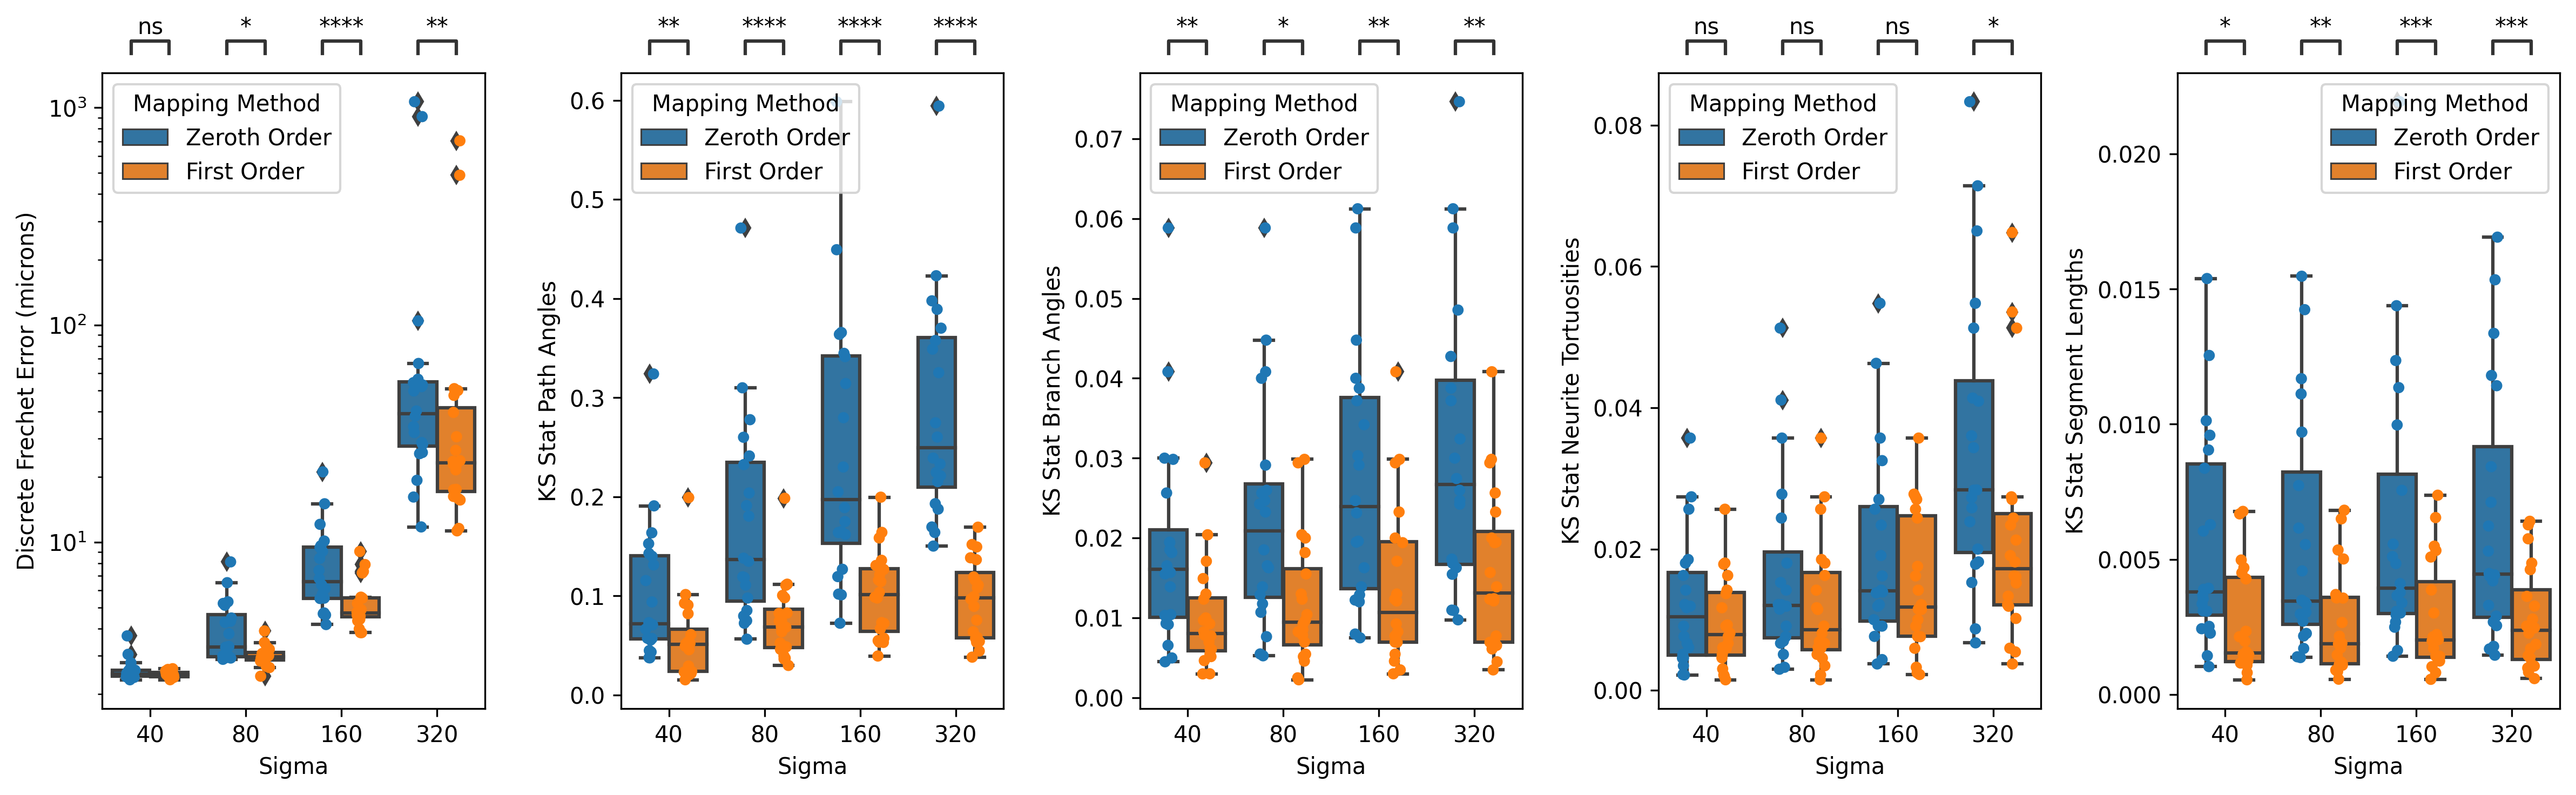

In [62]:
from statannotations.Annotator import Annotator

fig_args = {
            "x": "Sigma",
            "y": "Discrete Frechet Error (microns)",
            "hue": "Mapping Method",
            "data": df_err,
        }


f, axs = plt.subplots(1, 5, dpi=300)
ax = sns.stripplot(ax=axs[0], dodge=True, edgecolor='gray', legend=None, **fig_args)
sns.boxplot(ax=axs[0], **fig_args)
axs[0].set_yscale('log')

pairs = []
for sigma in df_err["Sigma"].unique():
    pairs.append(((sigma, "Zeroth Order"),(sigma, "First Order")))

annot = Annotator(ax, pairs, **fig_args)
annot.configure(test='Wilcoxon', text_format='star', loc='outside', verbose=2, comparisons_correction="Bonferroni")
annot.apply_test()
ax, test_results = annot.annotate()

with open(results_dir_morph / "morph-data.pickle", 'rb') as handle:
    data = pickle.load(handle)

df_morpho = pd.DataFrame(data=data)

for ax, par in zip(axs[1:], ["KS Stat Path Angles","KS Stat Branch Angles",  "KS Stat Neurite Tortuosities",  "KS Stat Segment Lengths"]):
    fig_args = {
            "x": "Sigma",
            "y": par,
            "hue": "Mapping Method",
            "data": df_morpho,
        }
    ax = sns.stripplot(ax=ax, dodge=True, edgecolor='gray', legend=None, **fig_args)
    sns.boxplot(ax=ax, **fig_args)

    annot = Annotator(ax, pairs, **fig_args)
    annot.configure(test='Wilcoxon', text_format='star', loc='outside', verbose=2, comparisons_correction="Bonferroni")
    annot.apply_test()
    ax, test_results = annot.annotate()

f.set_figheight(5)
f.set_figwidth(16)
f.tight_layout()

### Error vs sampling

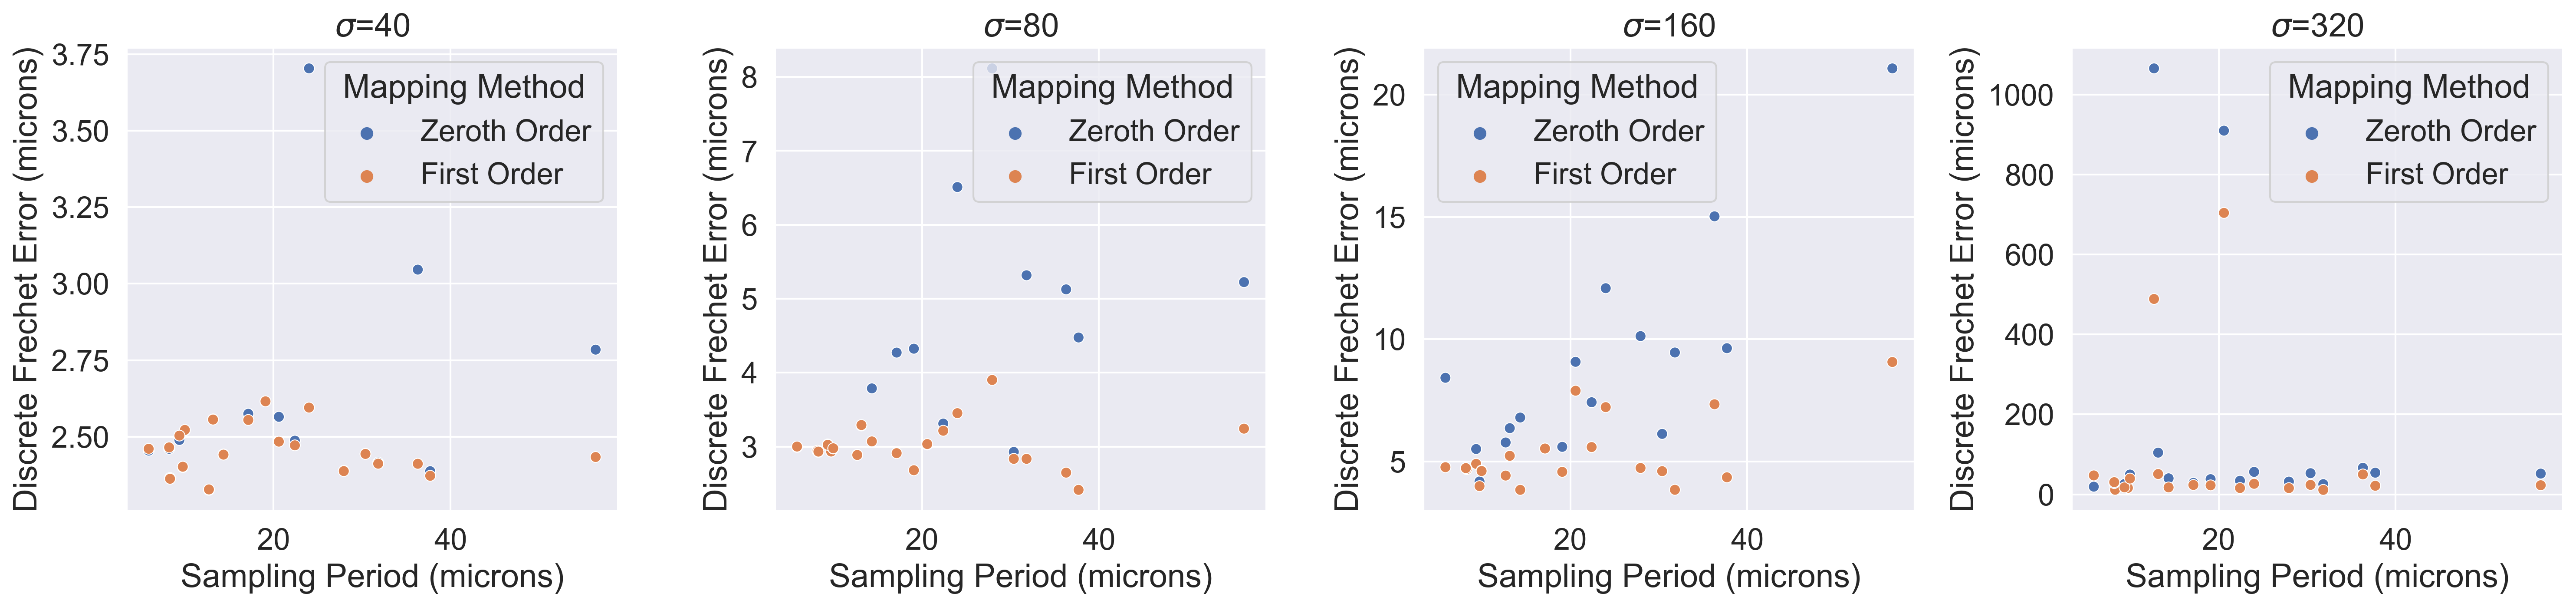

In [6]:
f, axs = plt.subplots(1, 4, dpi=300)
sns.set(font_scale=1.5)

for ax, sigma in zip(axs, np.sort(df_err["Sigma"].unique())):
    sns.scatterplot(data=df_err[df_err["Sigma"] == sigma], x="Sampling Period (microns)", y="Discrete Frechet Error (microns)", ax=ax, hue="Mapping Method")
    ax.set_title(rf"$\sigma$={sigma}")

f.set_figheight(5)
f.set_figwidth(20)
f.tight_layout()

### Plot examples

In [128]:
max_diff = 0

for sigma in df_err["Sigma"].unique():
    df_sigma = df_err[df_err["Sigma"] == sigma]

    for sample in df_sigma["Sample"].unique():
        z_err = df_sigma[(df_err["Sample"] == sample) & (df_err["Mapping Method"] == "Zeroth Order")]["Discrete Frechet Error (microns)"]
        f_err = df_sigma[(df_err["Sample"] == sample) & (df_err["Mapping Method"] == "First Order")]["Discrete Frechet Error (microns)"]
        diff = float(z_err) - float(f_err)
        if diff > max_diff:
            max_diff = diff
            max_sample = sample


print(f"{sample}: {max_diff}")

/var/folders/fq/9t66hqz51y5ddnygddgjtsmc0000gn/T/ipykernel_5535/2589939673.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  z_err = df_sigma[(df_err["Sample"] == sample) & (df_err["Mapping Method"] == "Zeroth Order")]["Discrete Frechet Error (microns)"]
/var/folders/fq/9t66hqz51y5ddnygddgjtsmc0000gn/T/ipykernel_5535/2589939673.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  f_err = df_sigma[(df_err["Sample"] == sample) & (df_err["Mapping Method"] == "First Order")]["Discrete Frechet Error (microns)"]
/var/folders/fq/9t66hqz51y5ddnygddgjtsmc0000gn/T/ipykernel_5535/2589939673.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  z_err = df_sigma[(df_err["Sample"] == sample) & (df_err["Mapping Method"] == "Zeroth Order")]["Discrete Frechet Error (microns)"]
/var/folders/fq/9t66hqz51y5ddnygddgjtsmc0000gn/T/ipykernel_5535/2589939673.py:8: UserWarning: Boolean Series key will be reindexed to 

AA1093: 576.7382016794845


/var/folders/fq/9t66hqz51y5ddnygddgjtsmc0000gn/T/ipykernel_5535/2589939673.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  z_err = df_sigma[(df_err["Sample"] == sample) & (df_err["Mapping Method"] == "Zeroth Order")]["Discrete Frechet Error (microns)"]
/var/folders/fq/9t66hqz51y5ddnygddgjtsmc0000gn/T/ipykernel_5535/2589939673.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  f_err = df_sigma[(df_err["Sample"] == sample) & (df_err["Mapping Method"] == "First Order")]["Discrete Frechet Error (microns)"]
/var/folders/fq/9t66hqz51y5ddnygddgjtsmc0000gn/T/ipykernel_5535/2589939673.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  z_err = df_sigma[(df_err["Sample"] == sample) & (df_err["Mapping Method"] == "Zeroth Order")]["Discrete Frechet Error (microns)"]
/var/folders/fq/9t66hqz51y5ddnygddgjtsmc0000gn/T/ipykernel_5535/2589939673.py:8: UserWarning: Boolean Series key will be reindexed to 

In [36]:
def check_duplicates_center(neuron):
    assert len(neuron.branches) == 1

    stack = []
    stack += neuron.branches[0]
    coords = []

    while len(stack) > 0:
        child = stack.pop()
        stack += child.children
        coords.append([child.x, child.y, child.z])

    
    # look for duplicates
    dupes = []
    seen = set()
    for coord in coords:
        coord = tuple(coord)
        if coord in seen:
            dupes.append(coord)
        else:
            seen.add(coord)

    # center coordinates
    if len(dupes) > 0:
        raise ValueError(f"Duplicate nodes")
    else:
        coords = np.array(coords)
        mx = np.amax(coords, axis=0)
        mn = np.amin(coords, axis=0)
        center = np.mean(np.array([mx, mn]), axis=0)
        stack = [neuron.branches[0]]

        while len(stack) > 0:
            child = stack.pop()
            stack += child.children

            child.x -= center[0]
            child.y -= center[1]
            child.z -= center[2]
        
    return neuron

def plot_neuron(neuron, ax, color, label, limits = None, ax2=None, center=False):
    neuron = replace_root(neuron)
    if center:
        neuron = check_duplicates_center(neuron)

    stack = []
    stack += neuron.branches[0]

    coords = []
    first1 = True
    first2 = True
    with tqdm(total=neuron.total_child_nodes()) as pbar:
        while stack:
            node = stack.pop()
            stack += node.children

            pbar.update(1)

            coords.append([node.x, node.y, node.z])
            for child in node.children:
                if first1:
                    first1 = False
                    ax.plot([node.x, child.x], [node.y, child.y], [node.z, child.z], c=color, linewidth=1, label=label)
                else:
                    ax.plot([node.x, child.x], [node.y, child.y], [node.z, child.z], c=color, linewidth=1)

                if limits is not None:
                    xmin, ymin, zmin = limits[0]
                    xmax, ymax, zmax = limits[1]

                    if node.x < xmin or node.x > xmax or node.y < ymin or node.y > ymax or node.z < zmin or node.z > zmax:
                        continue
                    else:
                        for child in node.children:
                            if first2:
                                first2 = False
                                ax2.plot([node.x, child.x], [node.y, child.y], [node.z, child.z], c=color, linewidth=1, alpha=0.5, label=label)
                            else:
                                ax2.plot([node.x, child.x], [node.y, child.y], [node.z, child.z], c=color, linewidth=1, alpha=0.5)
                                #ax2.scatter([node.x], [node.y], [node.z], c="blue", linewidth=1, alpha=0.5)


    return ax, ax2, coords
    

100%|█████████▉| 14667/14668 [00:16<00:00, 903.94it/s] 


<matplotlib.legend.Legend object at 0x1a9ff6ac0>

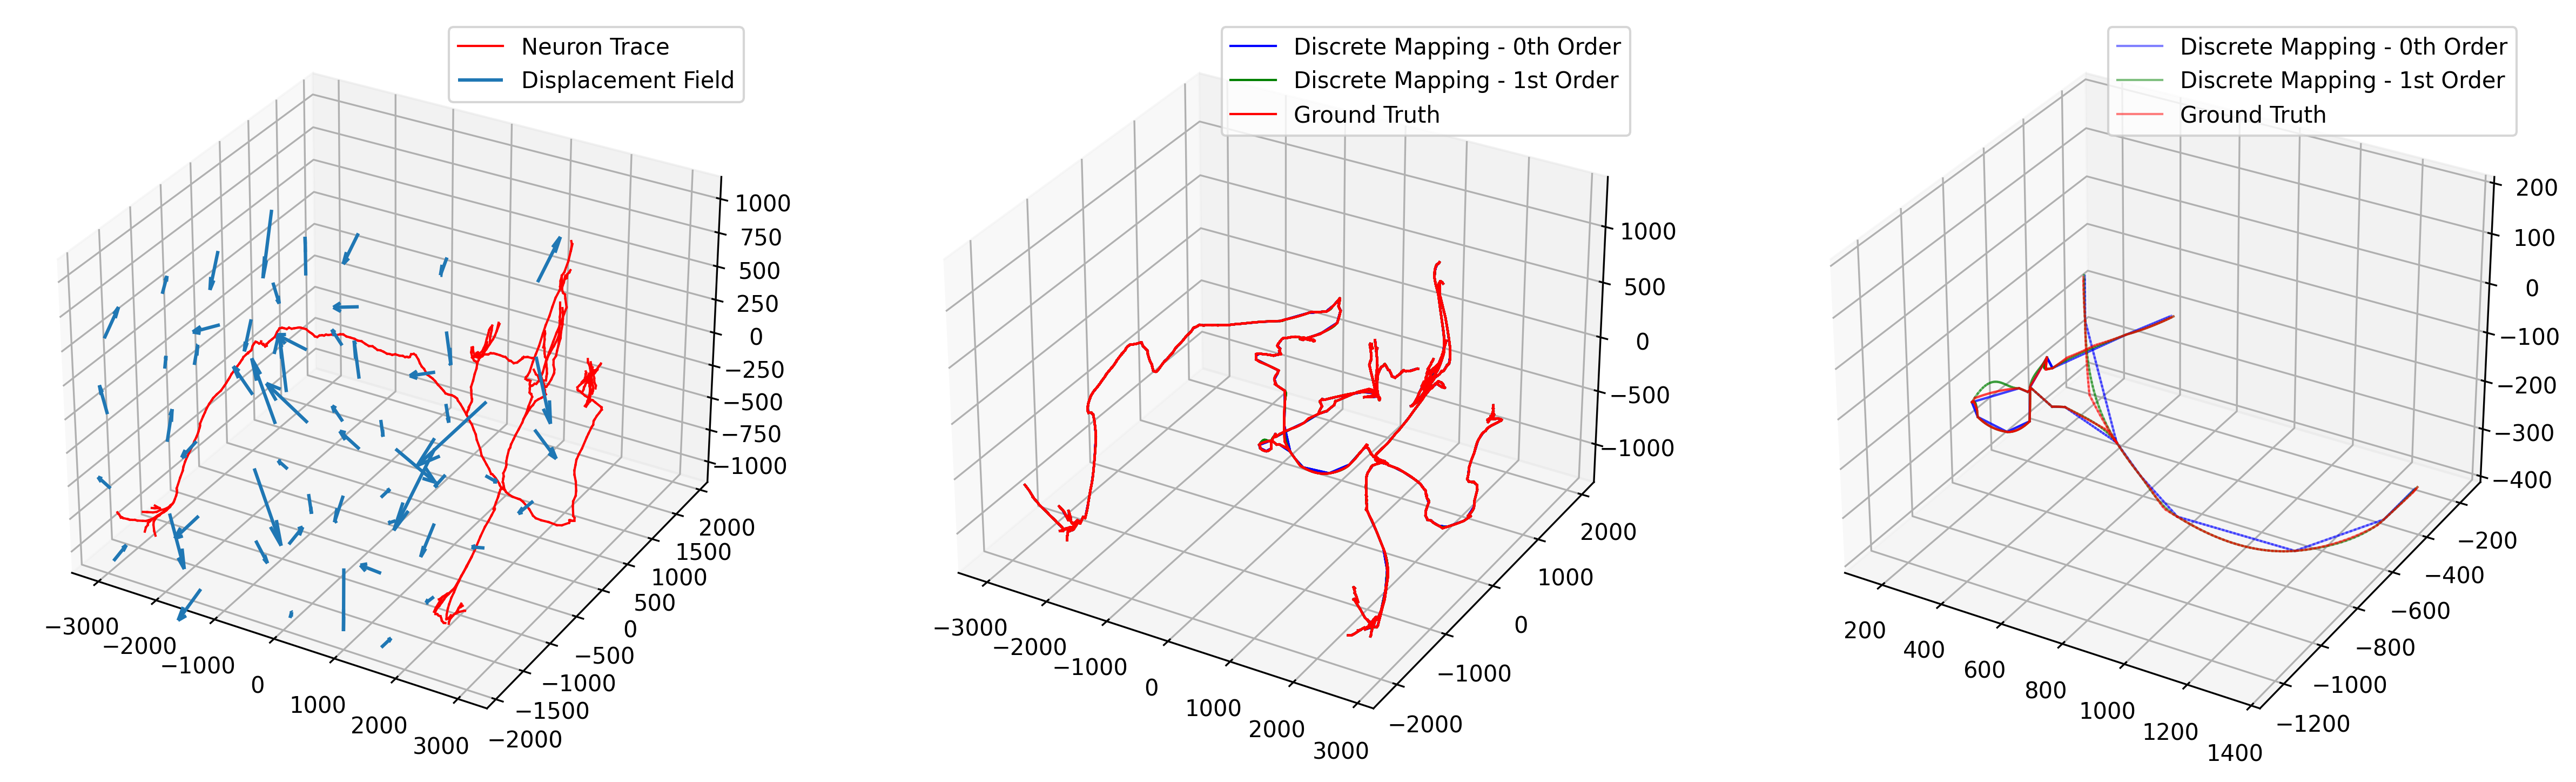

In [37]:
sample = "AA1093" 
#sample = "AA1087"

fig = plt.figure(figsize=(20, 10), dpi=300)
ax0 = fig.add_subplot(1, 3, 1, projection="3d")
ax1 = fig.add_subplot(1, 3, 2, projection="3d")
ax2 = fig.add_subplot(1, 3, 3, projection="3d")


fname = results_dir_morph.parent / f"{sample}.swc"
neuron = ngauge.Neuron.from_swc(fname)

ax0, _, coords = plot_neuron(neuron, ax=ax0, color='red', label="Neuron Trace", center=True)

fname = results_dir_morph.parents[1] / f"exp-morpho-diffeo-320.pickle"
with open(fname, "rb") as f:
    data = pickle.load(f)
xv = data["xv"]
phii = data["phii"]
ct = Diffeomorphism_Transform(xv, phii)

coords = np.array(coords)
mn = np.amin(coords, axis=0)
mx = np.amax(coords, axis=0)

xmin, ymin, zmin = mn[0], mn[1], mn[2]
xmax, ymax, zmax = mx[0], mx[1], mx[2]

xs = np.arange(xmin, xmax, (xmax - xmin) / 4)
ys = np.arange(ymin, ymax, (ymax - ymin) / 4)
zs = np.arange(zmin, zmax, (zmax - zmin) / 4)

og_coords = np.meshgrid(xs, ys, zs, indexing="ij")
og_coords = np.array(
    [og_coords[0].flatten(), og_coords[1].flatten(), og_coords[2].flatten()]
).T
new_coords = ct.evaluate(og_coords)

idxs2remove = []
for i, coord in enumerate(og_coords):
    if np.linalg.norm(coord - new_coords[i,:]) > 1000:
        idxs2remove.append(i)

og_coords = np.delete(og_coords, idxs2remove, axis=0)
new_coords = np.delete(new_coords, idxs2remove, axis=0)

ax0.quiver(
    og_coords[:, 0],
    og_coords[:, 1],
    og_coords[:, 2],
    new_coords[:,0] - og_coords[:, 0],
    new_coords[:,1] - og_coords[:, 1],
    new_coords[:,2] - og_coords[:, 2],
    #length=2,
    label="Displacement Field",
    # alpha=0.5,
)

# TRANSFORMED
if sample == "AA1093":
    xmin, xmax = 0, 1500
    ymin, ymax = -1400, 0
    zmin, zmax = -500, 200

else:
    xmin, xmax = -2700, -1800
    ymin, ymax = -2000, 2000
    zmin, zmax = 500, 800


fname = results_dir_morph / f"{sample}-sig-320-0.swc"
neuron = ngauge.Neuron.from_swc(fname)
ax1, ax2, _ = plot_neuron(neuron, ax1, color='blue', label="Discrete Mapping - 0th Order", limits = [(xmin, ymin, zmin), (xmax, ymax, zmax)], ax2=ax2)
  

fname = results_dir_morph / f"{sample}-sig-320-1.swc"
neuron = ngauge.Neuron.from_swc(fname)
ax1, ax2, _ = plot_neuron(neuron, ax1, color='green', label="Discrete Mapping - 1st Order", limits = [(xmin, ymin, zmin), (xmax, ymax, zmax)], ax2=ax2)      


fname = results_dir_morph / f"{sample}-sig-320-gt.swc"
neuron = ngauge.Neuron.from_swc(fname)
ax1, ax2, _ = plot_neuron(neuron, ax1, color='red', label="Ground Truth", limits = [(xmin, ymin, zmin), (xmax, ymax, zmax)], ax2=ax2)   

ax2.set_xlim(xmin+100,xmax-100)
ax2.set_ylim(ymin+100,ymax-100)
ax2.set_zlim(zmin+100,zmax)

ax0.legend()
ax1.legend()
ax2.legend()


### Plot displacement histograms

Computing transformed derivatives...: 100%|██████████| 7350/7350 [00:14<00:00, 508.93it/s]


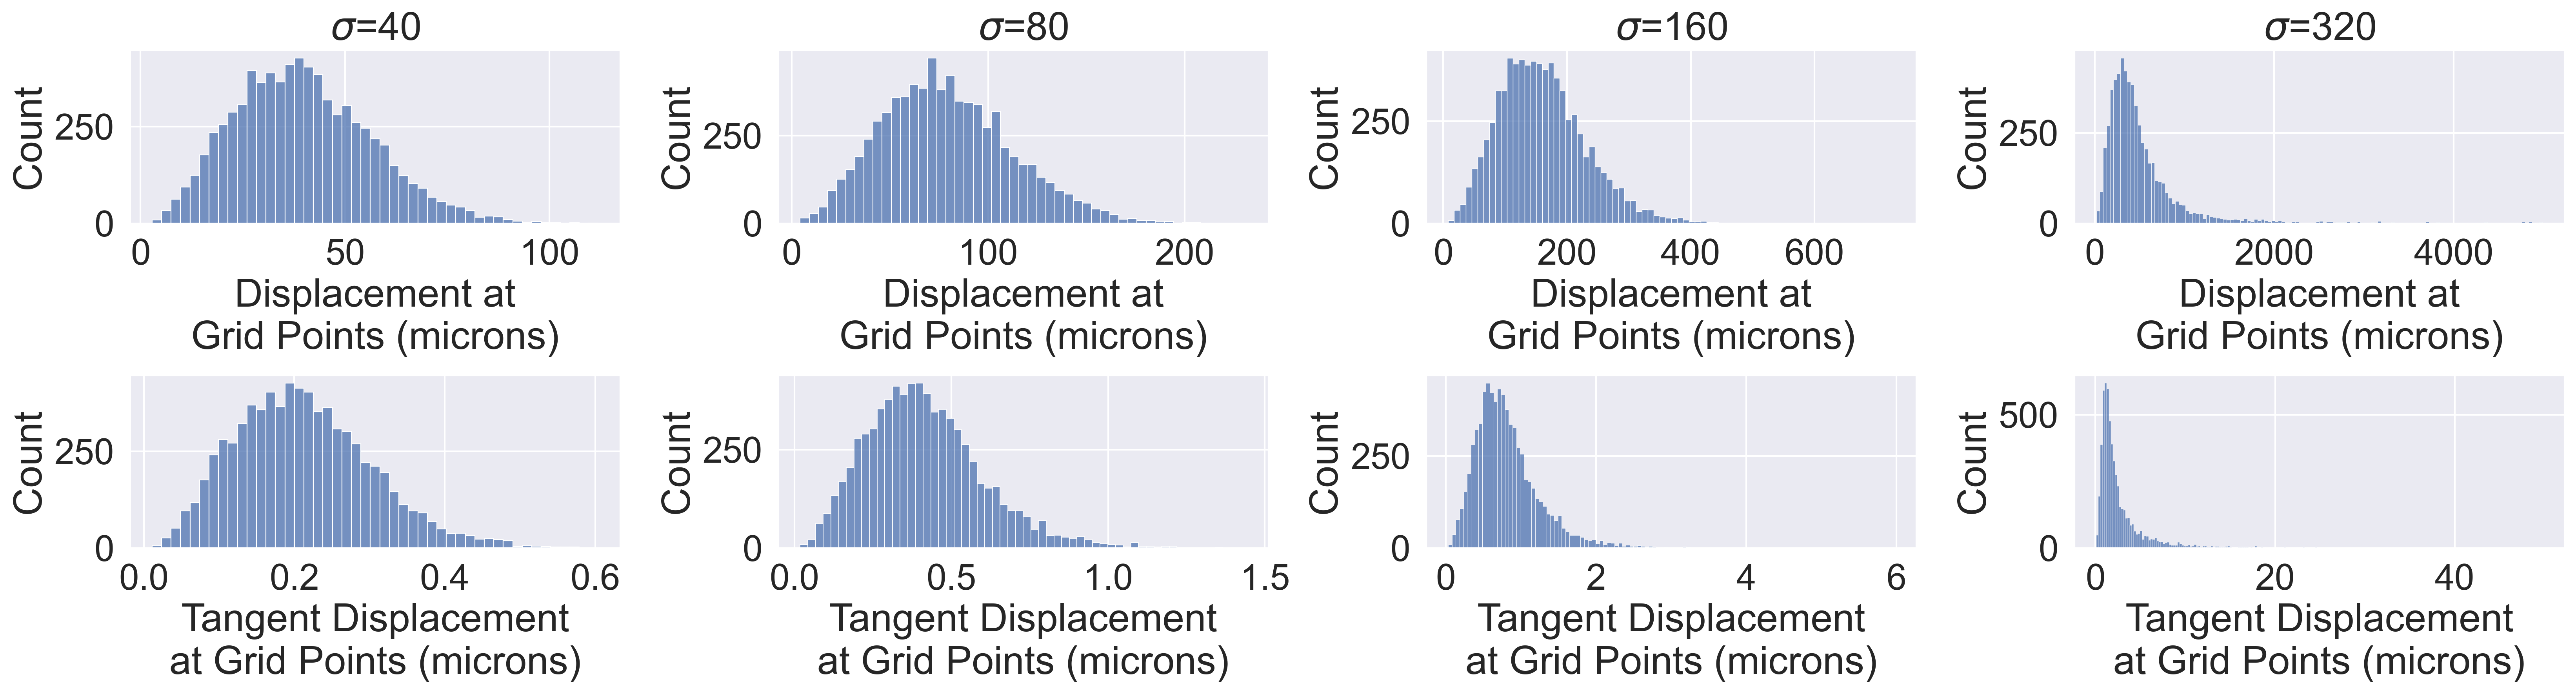

In [3]:
sns.set(font_scale=2)
fig, axs = plt.subplots(2, 4, figsize=(22,6), dpi=300)

for i, sigma in enumerate([str(40*2**i) for i in range(4)]):
    fname = results_dir_morph.parents[1] / f"exp-morpho-diffeo-{sigma}.pickle"
    with open(fname, "rb") as f:
        data = pickle.load(f)
    xv = data["xv"]
    phii = data["phii"]
    ct = Diffeomorphism_Transform(xv, phii)

    og_coords = ct.og_coords
    xmin = np.amin(og_coords[0])
    xmax = np.amax(og_coords[0])
    ymin = np.amin(og_coords[1])
    ymax = np.amax(og_coords[1])
    zmin = np.amin(og_coords[2])
    zmax = np.amax(og_coords[2])


    gap = 500
    xs = np.arange(xmin+gap, xmax-gap, gap)
    ys = np.arange(ymin+gap, ymax-gap, gap)
    zs = np.arange(zmin+gap, zmax-gap, gap)

    og_coords = np.meshgrid(xs, ys, zs, indexing="ij")
    og_coords = np.array(
        [og_coords[0].flatten(), og_coords[1].flatten(), og_coords[2].flatten()]
    ).T
    new_coords = ct.evaluate(og_coords)
    new_derivs = ct.D(og_coords, np.ones(og_coords.shape), verbose=True)

    position_diff = np.linalg.norm(og_coords - new_coords, axis=1)
    deriv_diff = np.linalg.norm(np.ones(og_coords.shape) - new_derivs, axis=1)
    data = {
        "Displacement at\nGrid Points (microns)": position_diff,
        "Tangent Displacement\nat Grid Points (microns)": deriv_diff,
    }
    
    df = pd.DataFrame(data=data)
    df_filter = df[df["Displacement at\nGrid Points (microns)"] < 5000]
    sns.histplot(data=df_filter, ax=axs[0, i], x="Displacement at\nGrid Points (microns)")
    df_filter = df[df["Tangent Displacement\nat Grid Points (microns)"] < 50]
    sns.histplot(data=df_filter, ax=axs[1, i], x="Tangent Displacement\nat Grid Points (microns)")

    axs[0,i].set_title(rf"$\sigma$={sigma}")
 
plt.tight_layout()

In [17]:
data

{
    'Displacement at\nGrid Points (microns)': array([32.51867363, 57.1289632 , 29.40764744, ..., 40.87345093,
       41.32490716, 33.31362871]),
    'Tangent Displacement\nat Grid Points (microns)': array([0.30643096, 0.34594795, 0.0958186 , ..., 0.30696239, 0.133409  ,
       0.03332299])
}